In [1]:
!pip install onnx2tf tensorflow onnx onnx-graphsurgeon ai-edge-litert sng4onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.3/468.3 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from scipy import signal
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configuración
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


In [ ]:
csv_files = glob.glob("/content/datos/*.csv")
print(f"Archivos encontrados: {len(csv_files)}")

Archivos encontrados: 19


In [ ]:
# Acumular todos los datos
all_data = []
for file in csv_files:
    df = pd.read_csv(file)
    all_data.append(df)

In [ ]:
data = pd.concat(all_data, ignore_index=True)
print(f"Total de muestras: {len(data)}")
print(f"Gestos únicos: {data['gesture_name'].unique()}")

Total de muestras: 55724
Gestos únicos: ['CERRAR_MANO' 'PINZA' 'SALUDAR' 'TOMAR_OBJ']


In [ ]:
# ============================
# 2. PREPROCESAMIENTO MEJORADO
# ===========================

def preprocess_signal(signal_data, fs=1000):
    """Preprocesamiento con filtrado y normalización Z-score"""

    # Filtro Butterworth paso-banda (20-450 Hz)
    nyquist = 0.5 * fs
    low = 20 / nyquist
    high = 450 / nyquist
    b, a = signal.butter(4, [low, high], btype='band')

    processed = np.zeros_like(signal_data)

    for i in range(signal_data.shape[1]):
        # Aplicar filtro
        filtered = signal.filtfilt(b, a, signal_data[:, i])

        # Rectificación
        rectified = np.abs(filtered)

        # Envelope (filtro paso-bajo a 5 Hz)
        b_env, a_env = signal.butter(2, 5/nyquist, btype='low')
        envelope = signal.filtfilt(b_env, a_env, rectified)

        # Normalización Z-score
        mean_val = np.mean(envelope)
        std_val = np.std(envelope) + 1e-8
        processed[:, i] = (envelope - mean_val) / std_val

    return processed

# Procesar datos por gesto
gesture_data = {}
for gesture in data['gesture_name'].unique():
    gesture_df = data[data['gesture_name'] == gesture]
    raw_signal = np.column_stack([
        gesture_df['emg1_raw'].values,
        gesture_df['emg2_raw'].values,
        gesture_df['emg3_raw'].values
    ])
    processed = preprocess_signal(raw_signal)
    gesture_data[gesture] = processed
    print(f"{gesture}: {len(processed)} muestras procesadas")

CERRAR_MANO: 13915 muestras procesadas
PINZA: 13925 muestras procesadas
SALUDAR: 13941 muestras procesadas
TOMAR_OBJ: 13943 muestras procesadas


In [ ]:
# ============================
# 3. CREACIÓN DE VENTANAS
# ============================

WINDOW_SIZE = 250  # Aumentado para capturar mejor los patrones
OVERLAP = 200      # 50% overlap

def create_windows(data_dict, window_size, overlap):
    """Crear ventanas deslizantes"""
    X, y = [], []

    for gesture_name, signal in data_dict.items():
        step = window_size - overlap
        n_windows = (len(signal) - window_size) // step + 1

        for i in range(n_windows):
            start = i * step
            end = start + window_size
            if end <= len(signal):
                window = signal[start:end]
                X.append(window)
                y.append(gesture_name)

    return np.array(X), np.array(y)

X, y_labels = create_windows(gesture_data, WINDOW_SIZE, OVERLAP)
print(f"\nDataset shape: X={X.shape}, y={len(y_labels)}")

# Codificar etiquetas
label_map = {label: idx for idx, label in enumerate(np.unique(y_labels))}
y = np.array([label_map[label] for label in y_labels])

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")



Dataset shape: X=(1096, 250, 3), y=1096
Train: (876, 250, 3), Test: (220, 250, 3)


In [ ]:
# ============================
# 4. DATA AUGMENTATION MEJORADO
# ============================

class EMGDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]

        if self.augment and np.random.random() < 0.5:
            # Augmentación más suave
            if np.random.random() < 0.33:
                # Ruido gaussiano suave
                noise = torch.randn_like(x) * 0.05
                x = x + noise
            elif np.random.random() < 0.66:
                # Escalado temporal suave
                scale = 1 + (np.random.random() - 0.5) * 0.2
                x = x * scale
            else:
                # Desplazamiento temporal pequeño
                shift = np.random.randint(-5, 5)
                x = torch.roll(x, shift, dims=0)

        return x, y

In [ ]:
# ============================
# 5. ARQUITECTURA SIMPLIFICADA
# ============================

class SimplifiedEMGNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=4):
        super(SimplifiedEMGNet, self).__init__()

        # CNN más simple
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.AdaptiveAvgPool1d(32)

        # LSTM bidireccional
        self.lstm = nn.LSTM(128, 64, batch_first=True, bidirectional=True, dropout=0.3)

        # Clasificador
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Input: (batch, seq_len, channels)
        x = x.transpose(1, 2)  # -> (batch, channels, seq_len)

        # CNN
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Preparar para LSTM
        x = x.transpose(1, 2)  # -> (batch, seq_len, features)

        # LSTM
        x, _ = self.lstm(x)

        # Global pooling
        x = torch.mean(x, dim=1)

        # Clasificador
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [ ]:
# ============================
# 6. ENTRENAMIENTO
# ============================

def train_model(model, train_loader, val_loader, epochs=200, lr=0.0021):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    best_val_acc = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += batch_y.size(0)
            train_correct += predicted.eq(batch_y).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += batch_y.size(0)
                val_correct += predicted.eq(batch_y).sum().item()

        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}")

    return history, best_val_acc

# Validación cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
    print(f"\n--- Fold {fold+1}/5 ---")

    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    # Datasets
    train_dataset = EMGDataset(X_fold_train, y_fold_train, augment=True)
    val_dataset = EMGDataset(X_fold_val, y_fold_val, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Modelo
    model = SimplifiedEMGNet().to(DEVICE)
    print(f"Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")

    # Entrenar
    history, best_acc = train_model(model, train_loader, val_loader, epochs=80)
    fold_results.append(best_acc)
    print(f"Fold {fold+1} - Mejor accuracy: {best_acc:.3f}")

print(f"\nValidación cruzada - Accuracy promedio: {np.mean(fold_results):.3f} ± {np.std(fold_results):.3f}")


--- Fold 1/5 ---
Parámetros totales: 143,812
Epoch 0: Train Acc: 0.263, Val Acc: 0.369
Epoch 10: Train Acc: 0.486, Val Acc: 0.477
Epoch 20: Train Acc: 0.584, Val Acc: 0.580
Epoch 30: Train Acc: 0.574, Val Acc: 0.614
Epoch 40: Train Acc: 0.667, Val Acc: 0.648
Epoch 50: Train Acc: 0.746, Val Acc: 0.716
Epoch 60: Train Acc: 0.750, Val Acc: 0.699
Epoch 70: Train Acc: 0.809, Val Acc: 0.744
Fold 1 - Mejor accuracy: 0.807

--- Fold 2/5 ---
Parámetros totales: 143,812
Epoch 0: Train Acc: 0.314, Val Acc: 0.394
Epoch 10: Train Acc: 0.525, Val Acc: 0.383
Epoch 20: Train Acc: 0.609, Val Acc: 0.509
Epoch 30: Train Acc: 0.629, Val Acc: 0.583
Epoch 40: Train Acc: 0.716, Val Acc: 0.589
Epoch 50: Train Acc: 0.763, Val Acc: 0.646
Epoch 60: Train Acc: 0.793, Val Acc: 0.623
Epoch 70: Train Acc: 0.836, Val Acc: 0.737
Fold 2 - Mejor accuracy: 0.777

--- Fold 3/5 ---
Parámetros totales: 143,812
Epoch 0: Train Acc: 0.278, Val Acc: 0.360
Epoch 10: Train Acc: 0.482, Val Acc: 0.474
Epoch 20: Train Acc: 0.578, V

Epoch 0: Train Acc: 0.292, Val Acc: 0.355
Epoch 10: Train Acc: 0.494, Val Acc: 0.495
Epoch 20: Train Acc: 0.594, Val Acc: 0.523
Epoch 30: Train Acc: 0.634, Val Acc: 0.591
Epoch 40: Train Acc: 0.694, Val Acc: 0.682
Epoch 50: Train Acc: 0.709, Val Acc: 0.745
Epoch 60: Train Acc: 0.777, Val Acc: 0.768
Epoch 70: Train Acc: 0.791, Val Acc: 0.791
Epoch 80: Train Acc: 0.846, Val Acc: 0.800
Epoch 90: Train Acc: 0.848, Val Acc: 0.845

Accuracy en test: 0.877

Reporte de clasificación:
              precision    recall  f1-score   support

 CERRAR_MANO       0.85      0.91      0.88        55
       PINZA       0.92      0.89      0.91        55
     SALUDAR       0.80      0.89      0.84        55
   TOMAR_OBJ       0.96      0.82      0.88        55

    accuracy                           0.88       220
   macro avg       0.88      0.88      0.88       220
weighted avg       0.88      0.88      0.88       220



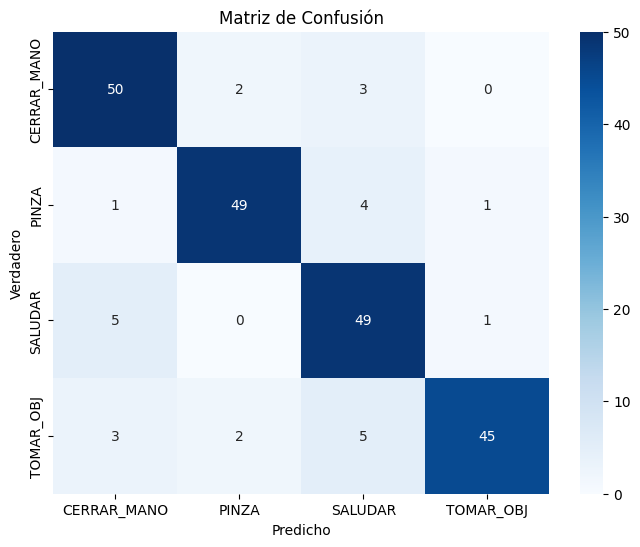

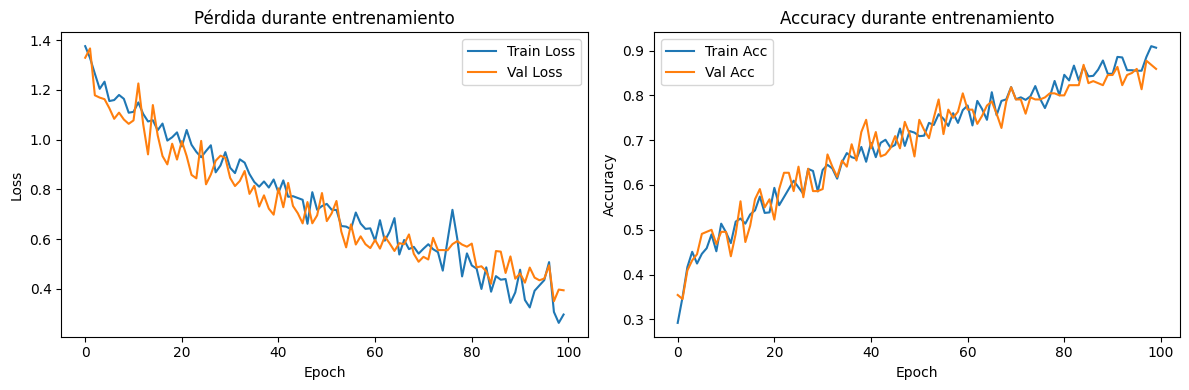

In [ ]:
# ============================
# 7. EVALUACIÓN FINAL
# ============================

# Entrenar modelo final con todos los datos de entrenamiento
train_dataset = EMGDataset(X_train, y_train, augment=True)
test_dataset = EMGDataset(X_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = SimplifiedEMGNet().to(DEVICE)
history, _ = train_model(model, train_loader, test_loader, epochs=100)

# Cargar mejor modelo
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Predicciones en test
all_preds, all_true = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(DEVICE)
        outputs = model(batch_X)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(batch_y.numpy())

# Métricas
accuracy = accuracy_score(all_true, all_preds)
print(f"\nAccuracy en test: {accuracy:.3f}")

# Reporte de clasificación
label_names = list(label_map.keys())
print("\nReporte de clasificación:")
print(classification_report(all_true, all_preds, target_names=label_names))

# Matriz de confusión
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

# Gráfica de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida durante entrenamiento')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy durante entrenamiento')
plt.tight_layout()
plt.show()


Accuracy en test: 0.877

Reporte de clasificación:
              precision    recall  f1-score   support

 CERRAR_MANO       0.85      0.91      0.88        55
       PINZA       0.92      0.89      0.91        55
     SALUDAR       0.80      0.89      0.84        55
   TOMAR_OBJ       0.96      0.82      0.88        55

    accuracy                           0.88       220
   macro avg       0.88      0.88      0.88       220
weighted avg       0.88      0.88      0.88       220



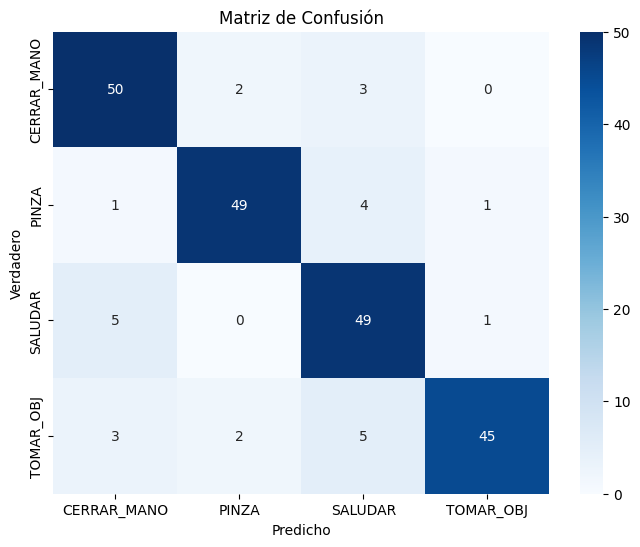

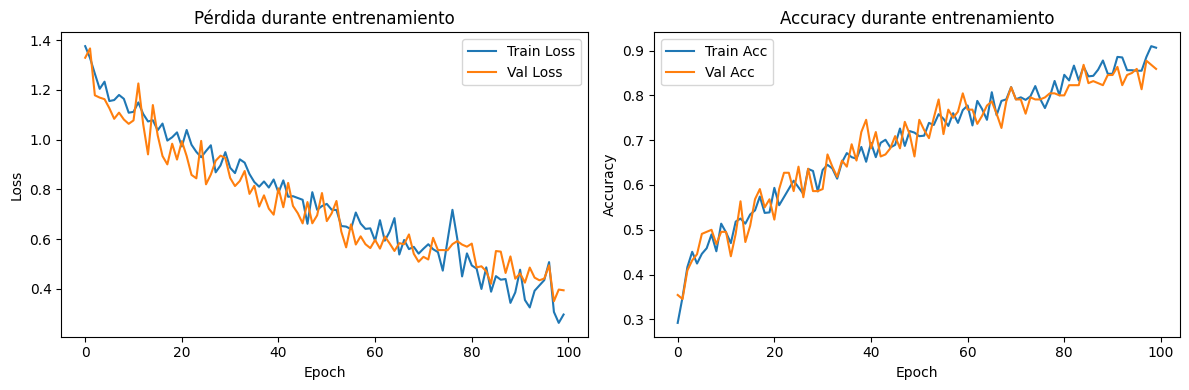

In [ ]:
 # Cargar mejor modelo
model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE)) # Load model to the correct device
model.to(DEVICE) # Move model to the device
model.eval()

# Predicciones en test
all_preds, all_true = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(DEVICE)
        outputs = model(batch_X)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(batch_y.numpy())

# Métricas
accuracy = accuracy_score(all_true, all_preds)
print(f"\nAccuracy en test: {accuracy:.3f}")

# Reporte de clasificación
label_names = list(label_map.keys())
print("\nReporte de clasificación:")
print(classification_report(all_true, all_preds, target_names=label_names))

# Matriz de confusión
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

# Gráfica de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida durante entrenamiento')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy durante entrenamiento')
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import onnx
import onnxruntime as ort
import os

# =====================================================================
# 1. DEFINIR LA ARQUITECTURA SIMPLIFIEDEMGNET
# =====================================================================

class SimplifiedEMGNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=4):
        super(SimplifiedEMGNet, self).__init__()

        # CNN más simple
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        # Reemplazar AdaptiveAvgPool1d con AvgPool1d compatible con ONNX
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)  # Esto da aprox. 31 elementos

        # LSTM bidireccional
        self.lstm = nn.LSTM(128, 64, batch_first=True, bidirectional=True, dropout=0.3)

        # Clasificador
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Input: (batch, seq_len, channels)
        x = x.transpose(1, 2)  # -> (batch, channels, seq_len)

        # CNN
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))  # 250 -> 125
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))  # 125 -> 62
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))  # 62 -> 31

        # Preparar para LSTM
        x = x.transpose(1, 2)  # -> (batch, seq_len, features)

        # LSTM
        x, _ = self.lstm(x)

        # Global pooling
        x = torch.mean(x, dim=1)

        # Clasificador
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# =====================================================================
# 2. FUNCIÓN DE CONVERSIÓN
# =====================================================================

def convert_pth_to_onnx(pth_path="best_model.pth", onnx_path="emg_model.onnx"):
    """
    Convertir archivo .pth a ONNX de forma directa
    """

    print("="*50)
    print("CONVERSIÓN PYTORCH → ONNX")
    print("="*50)

    # Verificar archivo
    if not os.path.exists(pth_path):
        print(f"❌ Error: No se encuentra el archivo {pth_path}")
        return False

    print(f"📁 Archivo PyTorch: {pth_path}")
    print(f"📁 Archivo ONNX: {onnx_path}")

    # Detectar dispositivo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🔧 Dispositivo: {device}")

    try:
        # 1. Cargar modelo y inspeccionar estructura
        print("\n1. Inspeccionando modelo PyTorch...")

        checkpoint = torch.load(pth_path, map_location=device)
        print(f"✅ Archivo cargado - Tipo: {type(checkpoint)}")

        # Inspeccionar las claves para entender la estructura
        if isinstance(checkpoint, dict):
            print("🔍 Claves encontradas en el checkpoint:")
            for key in list(checkpoint.keys())[:10]:  # Mostrar primeras 10 claves
                print(f"   - {key}: {checkpoint[key].shape if hasattr(checkpoint[key], 'shape') else type(checkpoint[key])}")
            if len(checkpoint.keys()) > 10:
                print(f"   ... y {len(checkpoint.keys()) - 10} más")

        # 2. Intentar crear modelo compatible
        print("\n2. Creando modelo compatible con ONNX...")

        # Determinar número de clases desde los pesos
        num_classes = 4  # Default
        if 'fc2.weight' in checkpoint:
            num_classes = checkpoint['fc2.weight'].shape[0]
            print(f"✅ Detectado {num_classes} clases desde fc2.weight")

        model = SimplifiedEMGNet(input_channels=3, num_classes=num_classes)

        # Intentar cargar pesos
        try:
            model.load_state_dict(checkpoint)
            print("✅ Pesos cargados directamente")
        except Exception as e:
            print(f"⚠️ Error cargando pesos directamente: {e}")
            print("🔧 Intentando cargar pesos parcialmente...")

            # Cargar pesos que coincidan
            model_dict = model.state_dict()
            filtered_dict = {}

            for k, v in checkpoint.items():
                if k in model_dict and model_dict[k].shape == v.shape:
                    filtered_dict[k] = v
                    print(f"   ✅ {k}: {v.shape}")
                else:
                    print(f"   ❌ {k}: {v.shape if hasattr(v, 'shape') else type(v)} (no compatible)")

            model_dict.update(filtered_dict)
            model.load_state_dict(model_dict)
            print(f"✅ Cargados {len(filtered_dict)} / {len(checkpoint)} pesos")

        model.to(device)
        model.eval()

        total_params = sum(p.numel() for p in model.parameters())
        print(f"✅ Modelo final - Parámetros: {total_params:,}")

        # 3. Crear tensor de entrada
        print("\n3. Preparando entrada...")

        # Input: (batch_size=1, seq_len=250, channels=3)
        dummy_input = torch.randn(1, 250, 3, device=device, dtype=torch.float32)
        print(f"✅ Tensor de entrada: {dummy_input.shape}")

        # Verificar que funciona
        with torch.no_grad():
            test_output = model(dummy_input)
        print(f"✅ Test exitoso - Salida: {test_output.shape}")

        # 4. Exportar a ONNX con configuración robusta
        print("\n4. Exportando a ONNX...")

        # Configuración compatible con versiones más antiguas de PyTorch
        torch.onnx.export(
            model,                      # Modelo
            dummy_input,                # Entrada de ejemplo
            onnx_path,                  # Archivo de salida
            export_params=True,         # Exportar parámetros
            opset_version=11,           # Versión ONNX compatible con más sistemas
            do_constant_folding=True,   # Optimización
            input_names=['emg_input'],  # Nombre entrada
            output_names=['gesture_output'],  # Nombre salida
            dynamic_axes={
                'emg_input': {0: 'batch_size'},
                'gesture_output': {0: 'batch_size'}
            },
            verbose=False               # Reducir verbosidad
        )

        print("✅ Exportación completada")

        # 5. Verificar modelo ONNX
        print("\n5. Verificando modelo ONNX...")

        # Verificar estructura
        onnx_model = onnx.load(onnx_path)
        onnx.checker.check_model(onnx_model)
        print("✅ Modelo ONNX válido")

        # Verificar con ONNX Runtime
        ort_session = ort.InferenceSession(onnx_path)

        input_info = ort_session.get_inputs()[0]
        output_info = ort_session.get_outputs()[0]

        print(f"✅ Input: {input_info.name} {input_info.shape}")
        print(f"✅ Output: {output_info.name} {output_info.shape}")

        # 6. Test comparativo con múltiples muestras
        print("\n6. Comparando PyTorch vs ONNX...")

        # Crear varios datos de prueba
        test_samples = 5
        test_data = torch.randn(test_samples, 250, 3, device=device)

        # Predicciones PyTorch
        model.eval()
        with torch.no_grad():
            pytorch_outputs = []
            for i in range(test_samples):
                output = model(test_data[i:i+1])
                pytorch_outputs.append(output.cpu().numpy())
            pytorch_outputs = np.concatenate(pytorch_outputs, axis=0)
            pytorch_preds = np.argmax(pytorch_outputs, axis=1)

        # Predicciones ONNX
        onnx_preds = []
        onnx_outputs = []
        for i in range(test_samples):
            sample = test_data[i:i+1].cpu().numpy().astype(np.float32)
            onnx_input = {input_info.name: sample}
            onnx_output = ort_session.run(None, onnx_input)[0]
            onnx_outputs.append(onnx_output)
            onnx_preds.append(np.argmax(onnx_output[0]))

        onnx_preds = np.array(onnx_preds)
        onnx_outputs = np.concatenate(onnx_outputs, axis=0)

        # Calcular concordancia
        pred_agreement = np.mean(pytorch_preds == onnx_preds)

        # Calcular diferencia numérica en las salidas
        output_diff = np.mean(np.abs(pytorch_outputs - onnx_outputs))

        print(f"✅ Concordancia en predicciones: {pred_agreement:.3f}")
        print(f"✅ Diferencia promedio en outputs: {output_diff:.6f}")

        if pred_agreement < 0.8:
            print("⚠️ Advertencia: Baja concordancia en predicciones")
        elif output_diff > 0.01:
            print("⚠️ Advertencia: Diferencias numéricas significativas")
        else:
            print("✅ Conversión exitosa - Resultados consistentes")

        # Información del archivo
        file_size = os.path.getsize(onnx_path)
        print(f"✅ Tamaño archivo: {file_size:,} bytes ({file_size/1024/1024:.1f} MB)")

        return True

    except Exception as e:
        print(f"❌ Error en conversión: {e}")
        print("\n🔧 SUGERENCIAS:")
        print("1. Verifica que el archivo best_model.pth sea válido")
        print("2. Asegúrate de tener las librerías instaladas: pip install torch onnx onnxruntime")
        print("3. Si persiste el error, puede ser una incompatibilidad de arquitectura")

        return False

# =====================================================================
# 3. GENERAR CÓDIGO DE USO
# =====================================================================

def generate_usage_example(onnx_path="emg_model.onnx"):
    """
    Generar ejemplo de uso del modelo ONNX
    """

    usage_code = f'''# Ejemplo de uso del modelo EMG ONNX
import numpy as np
import onnxruntime as ort

# Cargar modelo
session = ort.InferenceSession("{onnx_path}")

# Información del modelo
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
print(f"Input: {{input_name}}")
print(f"Output: {{output_name}}")

# Nombres de gestos (ajustar según tu dataset)
gesture_names = ['CERRAR_MANO', 'PINZA', 'SALUDAR', 'TOMAR_OBJ']

def predict_gesture(emg_data):
    """
    Predecir gesto desde datos EMG
    emg_data: numpy array shape (250, 3)
    """
    # Asegurar forma correcta
    if emg_data.shape != (250, 3):
        raise ValueError(f"Se esperaba shape (250, 3), recibido: {{emg_data.shape}}")

    # Añadir dimensión batch
    input_data = {{input_name: emg_data.reshape(1, 250, 3).astype(np.float32)}}

    # Predicción
    output = session.run([output_name], input_data)[0]

    # Resultado
    probabilities = output[0]
    predicted_class = np.argmax(probabilities)
    confidence = np.max(probabilities)

    return {{
        'gesture': gesture_names[predicted_class],
        'class_id': predicted_class,
        'confidence': confidence,
        'probabilities': probabilities
    }}

# Ejemplo de uso
if __name__ == "__main__":
    # Datos de ejemplo (reemplazar con datos reales)
    dummy_emg = np.random.randn(250, 3).astype(np.float32)

    # Predecir
    result = predict_gesture(dummy_emg)

    print(f"Gesto predicho: {{result['gesture']}}")
    print(f"Confianza: {{result['confidence']:.3f}}")
    print(f"Clase ID: {{result['class_id']}}")
'''

    with open("emg_usage_example.py", "w") as f:
        f.write(usage_code)

    print(f"✅ Ejemplo de uso guardado: emg_usage_example.py")

# =====================================================================
# 4. FUNCIÓN PRINCIPAL
# =====================================================================

def main():
    """
    Función principal - convertir best_model.pth a ONNX
    """

    print("🚀 Iniciando conversión PyTorch → ONNX...")

    # Parámetros con la ruta específica
    pth_file = "/content/best_model.pth"  # Ruta específica
    onnx_file = "emg_model.onnx"

    # Verificar que el archivo existe
    if not os.path.exists(pth_file):
        print(f"❌ Error: No se encuentra {pth_file}")
        print("🔍 Archivos en /content/:")
        try:
            for file in os.listdir("/content/"):
                if file.endswith(".pth"):
                    print(f"   - {file}")
        except:
            pass
        return

    # Convertir
    success = convert_pth_to_onnx(pth_file, onnx_file)

    if success:
        print("\n📝 Generando ejemplo de uso...")
        generate_usage_example(onnx_file)

        print("\n" + "="*50)
        print("🎉 CONVERSIÓN COMPLETADA")
        print("="*50)
        print(f"✅ Modelo ONNX: {onnx_file}")
        print(f"✅ Ejemplo uso: emg_usage_example.py")
        print(f"✅ Listo para usar en cualquier plataforma")

        print("\n🔧 INSTALACIÓN REQUERIDA:")
        print("pip install onnxruntime")

        print("\n📚 USO BÁSICO:")
        print("import onnxruntime as ort")
        print(f"session = ort.InferenceSession('{onnx_file}')")
        print("# Ver emg_usage_example.py para código completo")

    else:
        print("\n❌ CONVERSIÓN FALLIDA")
        print("🔧 POSIBLES SOLUCIONES:")
        print("1. Verifica que /content/best_model.pth existe y es válido")
        print("2. El modelo puede tener una arquitectura ligeramente diferente")
        print("3. Intenta regenerar el modelo PyTorch original")
        print("4. Instala/actualiza librerías: pip install torch==1.13.1 onnx onnxruntime")

# Ejecutar
if __name__ == "__main__":
    main()

🚀 Iniciando conversión PyTorch → ONNX...
CONVERSIÓN PYTORCH → ONNX
📁 Archivo PyTorch: /content/best_model.pth
📁 Archivo ONNX: emg_model.onnx
🔧 Dispositivo: cuda

1. Inspeccionando modelo PyTorch...
✅ Archivo cargado - Tipo: <class 'collections.OrderedDict'>
🔍 Claves encontradas en el checkpoint:
   - conv1.weight: torch.Size([32, 3, 5])
   - conv1.bias: torch.Size([32])
   - bn1.weight: torch.Size([32])
   - bn1.bias: torch.Size([32])
   - bn1.running_mean: torch.Size([32])
   - bn1.running_var: torch.Size([32])
   - bn1.num_batches_tracked: torch.Size([])
   - conv2.weight: torch.Size([64, 32, 5])
   - conv2.bias: torch.Size([64])
   - bn2.weight: torch.Size([64])
   ... y 23 más

2. Creando modelo compatible con ONNX...
✅ Detectado 4 clases desde fc2.weight
✅ Pesos cargados directamente
✅ Modelo final - Parámetros: 143,812

3. Preparando entrada...
✅ Tensor de entrada: torch.Size([1, 250, 3])
✅ Test exitoso - Salida: torch.Size([1, 4])

4. Exportando a ONNX...
✅ Exportación completad

🧪 INICIANDO EVALUACIÓN DEL MODELO ONNX
1. Cargando dataset...
Cargando dataset EMG...
Archivos encontrados: 19
Total de muestras: 55724
Gestos únicos: ['CERRAR_MANO' 'PINZA' 'SALUDAR' 'TOMAR_OBJ']
2. Procesando datos...
CERRAR_MANO: 13915 muestras procesadas
PINZA: 13925 muestras procesadas
SALUDAR: 13941 muestras procesadas
TOMAR_OBJ: 13943 muestras procesadas
3. Dividiendo datos...
Dataset dividido - Train: (767, 250, 3), Test: (329, 250, 3)
4. Evaluando modelo ONNX...
EVALUACIÓN DEL MODELO ONNX
Dataset de prueba: (329, 250, 3)
Clases: ['CERRAR_MANO' 'PINZA' 'SALUDAR' 'TOMAR_OBJ']
Modelo ONNX cargado:
  Input: emg_input ['batch_size', 250, 3]
  Output: gesture_output ['batch_size', 4]

Realizando predicciones en 329 muestras...

📊 MÉTRICAS PRINCIPALES:
  Accuracy: 0.9058
  Precision (weighted): 0.9089
  Recall (weighted): 0.9058
  F1-score (weighted): 0.9064

📈 MÉTRICAS POR CLASE:
  CERRAR_MANO:
    Precision: 0.8824
    Recall: 0.9146
    F1-score: 0.8982
    Support: 82
  PINZA:
  

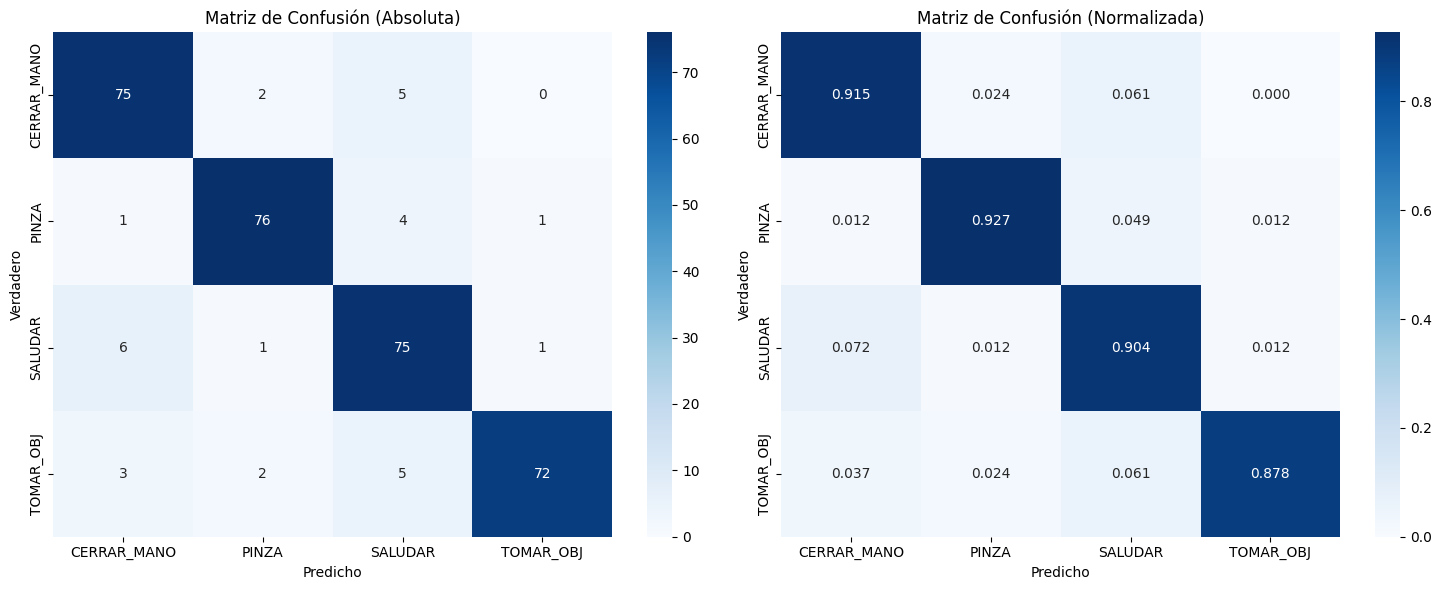


🎯 ANÁLISIS DE CONFIANZA:
  Confianza promedio: 3.9819
  Confianza en predicciones correctas: 4.1833
  Confianza en predicciones incorrectas: 2.0460


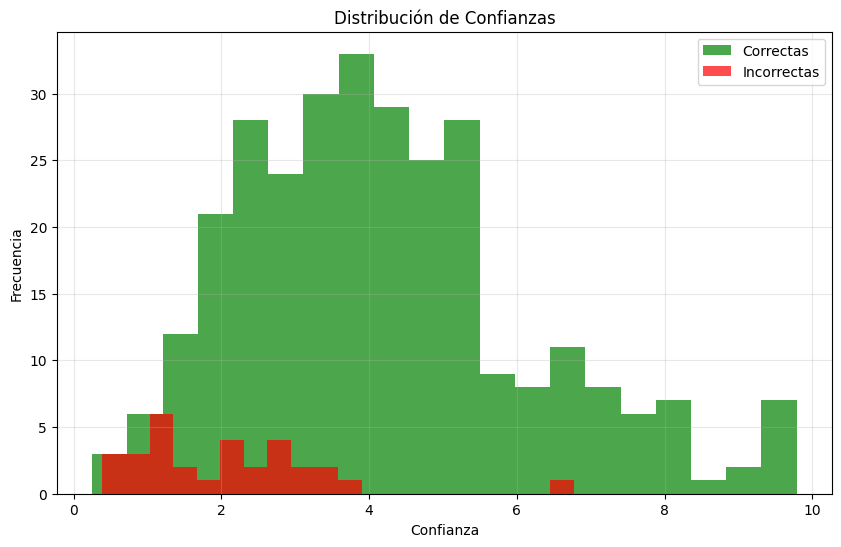


🔍 ANÁLISIS POR UMBRAL DE CONFIANZA:
  Umbral 0.5: 0.9110 accuracy en 99.1% de muestras
  Umbral 0.6: 0.9136 accuracy en 98.5% de muestras
  Umbral 0.7: 0.9133 accuracy en 98.2% de muestras
  Umbral 0.8: 0.9161 accuracy en 97.9% de muestras
  Umbral 0.9: 0.9190 accuracy en 97.6% de muestras

⚠️ No se pudo calcular ROC AUC: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

❌ ERRORES MÁS COMUNES:
  SALUDAR → CERRAR_MANO: 6 veces (1.8%)
  CERRAR_MANO → SALUDAR: 5 veces (1.5%)
  TOMAR_OBJ → SALUDAR: 5 veces (1.5%)
  PINZA → SALUDAR: 4 veces (1.2%)
  TOMAR_OBJ → CERRAR_MANO: 3 veces (0.9%)

🎯 RESUMEN FINAL
Accuracy: 0.9058
Precision: 0.9089
Recall: 0.9058
F1-score: 0.9064
Confianza promedio: 3.9819

📁 Archivos generados:
  - confusion_matrix_onnx.png
  - confidence_distribution_onnx.png

✅ Evaluación completada exitosamente


In [ ]:
import numpy as np
import pandas as pd
import onnxruntime as ort
import glob
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# =====================================================================
# 1. CARGAR Y PREPROCESAR DATASET EMG
# =====================================================================

def load_emg_dataset(csv_path="/content/datos/*.csv"):
    """Cargar dataset EMG desde archivos CSV"""
    print("Cargando dataset EMG...")
    csv_files = glob.glob(csv_path)

    if not csv_files:
        print(f"No se encontraron archivos CSV en {csv_path}")
        return None, None, None, None

    print(f"Archivos encontrados: {len(csv_files)}")

    all_data = []
    for file in csv_files:
        df = pd.read_csv(file)
        all_data.append(df)

    data = pd.concat(all_data, ignore_index=True)
    print(f"Total de muestras: {len(data)}")
    print(f"Gestos únicos: {data['gesture_name'].unique()}")

    return data

def preprocess_signal(signal_data, fs=1000):
    """Preprocesamiento EMG idéntico al entrenamiento"""
    nyquist = 0.5 * fs
    low = 20 / nyquist
    high = 450 / nyquist
    b, a = signal.butter(4, [low, high], btype='band')

    processed = np.zeros_like(signal_data)

    for i in range(signal_data.shape[1]):
        # Filtro
        filtered = signal.filtfilt(b, a, signal_data[:, i])
        # Rectificación
        rectified = np.abs(filtered)
        # Envelope
        b_env, a_env = signal.butter(2, 5/nyquist, btype='low')
        envelope = signal.filtfilt(b_env, a_env, rectified)
        # Normalización Z-score
        mean_val = np.mean(envelope)
        std_val = np.std(envelope) + 1e-8
        processed[:, i] = (envelope - mean_val) / std_val

    return processed

def create_test_dataset(data, window_size=250, overlap=200):
    """Crear dataset de prueba con ventanas deslizantes"""

    gesture_data = {}
    for gesture in data['gesture_name'].unique():
        gesture_df = data[data['gesture_name'] == gesture]
        raw_signal = np.column_stack([
            gesture_df['emg1_raw'].values,
            gesture_df['emg2_raw'].values,
            gesture_df['emg3_raw'].values
        ])
        processed = preprocess_signal(raw_signal)
        gesture_data[gesture] = processed
        print(f"{gesture}: {len(processed)} muestras procesadas")

    X, y = [], []
    for gesture_name, signal in gesture_data.items():
        step = window_size - overlap
        n_windows = (len(signal) - window_size) // step + 1

        for i in range(n_windows):
            start = i * step
            end = start + window_size
            if end <= len(signal):
                window = signal[start:end]
                X.append(window)
                y.append(gesture_name)

    X = np.array(X)
    y_labels = np.array(y)

    unique_gestures = np.unique(y_labels)
    label_map = {label: idx for idx, label in enumerate(unique_gestures)}
    y = np.array([label_map[label] for label in y_labels])

    return X, y, label_map, unique_gestures

# =====================================================================
# 2. CLASE PARA PREDICCIÓN CON ONNX
# =====================================================================

class ONNXEMGClassifier:
    def __init__(self, onnx_path):
        """Inicializar clasificador ONNX"""
        self.session = ort.InferenceSession(onnx_path)
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name

        # Información del modelo
        input_info = self.session.get_inputs()[0]
        output_info = self.session.get_outputs()[0]

        print(f"Modelo ONNX cargado:")
        print(f"  Input: {input_info.name} {input_info.shape}")
        print(f"  Output: {output_info.name} {output_info.shape}")

    def predict_batch(self, X_batch):
        """Predecir lote de muestras"""
        predictions = []
        probabilities = []

        for sample in X_batch:
            # Asegurar formato correcto
            input_data = {self.input_name: sample.reshape(1, 250, 3).astype(np.float32)}

            # Predicción
            output = self.session.run([self.output_name], input_data)[0]

            # Extraer resultados
            probs = output[0]
            pred_class = np.argmax(probs)

            predictions.append(pred_class)
            probabilities.append(probs)

        return np.array(predictions), np.array(probabilities)

    def predict_single(self, sample):
        """Predecir una sola muestra"""
        input_data = {self.input_name: sample.reshape(1, 250, 3).astype(np.float32)}
        output = self.session.run([self.output_name], input_data)[0]

        probabilities = output[0]
        predicted_class = np.argmax(probabilities)
        confidence = np.max(probabilities)

        return predicted_class, probabilities, confidence

# =====================================================================
# 3. EVALUACIÓN COMPLETA CON MÉTRICAS
# =====================================================================

def evaluate_onnx_model(onnx_path, X_test, y_test, gesture_names,
                       test_size_limit=None, verbose=True):
    """
    Evaluación completa del modelo ONNX
    """

    print("="*60)
    print("EVALUACIÓN DEL MODELO ONNX")
    print("="*60)

    # Limitar tamaño de test si es muy grande
    if test_size_limit and len(X_test) > test_size_limit:
        indices = np.random.choice(len(X_test), test_size_limit, replace=False)
        X_test = X_test[indices]
        y_test = y_test[indices]
        print(f"Usando {test_size_limit} muestras de prueba (muestra aleatoria)")

    print(f"Dataset de prueba: {X_test.shape}")
    print(f"Clases: {gesture_names}")

    # Cargar clasificador
    classifier = ONNXEMGClassifier(onnx_path)

    # Hacer predicciones
    print(f"\nRealizando predicciones en {len(X_test)} muestras...")
    y_pred, y_probs = classifier.predict_batch(X_test)

    # =====================================================================
    # MÉTRICAS BÁSICAS
    # =====================================================================

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print(f"\n📊 MÉTRICAS PRINCIPALES:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision (weighted): {precision:.4f}")
    print(f"  Recall (weighted): {recall:.4f}")
    print(f"  F1-score (weighted): {f1:.4f}")

    # =====================================================================
    # MÉTRICAS POR CLASE
    # =====================================================================

    print(f"\n📈 MÉTRICAS POR CLASE:")
    precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
        y_test, y_pred, average=None
    )

    for i, gesture in enumerate(gesture_names):
        print(f"  {gesture}:")
        print(f"    Precision: {precision_per_class[i]:.4f}")
        print(f"    Recall: {recall_per_class[i]:.4f}")
        print(f"    F1-score: {f1_per_class[i]:.4f}")
        print(f"    Support: {support[i]}")

    # =====================================================================
    # REPORTE CLASIFICACIÓN COMPLETO
    # =====================================================================

    print(f"\n📋 REPORTE DE CLASIFICACIÓN COMPLETO:")
    print(classification_report(y_test, y_pred, target_names=gesture_names))

    # =====================================================================
    # MATRIZ DE CONFUSIÓN
    # =====================================================================

    cm = confusion_matrix(y_test, y_pred)

    # Matriz de confusión normalizada
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Graficar matriz de confusión
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Matriz absoluta
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=gesture_names, yticklabels=gesture_names, ax=ax1)
    ax1.set_title('Matriz de Confusión (Absoluta)')
    ax1.set_ylabel('Verdadero')
    ax1.set_xlabel('Predicho')

    # Matriz normalizada
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=gesture_names, yticklabels=gesture_names, ax=ax2)
    ax2.set_title('Matriz de Confusión (Normalizada)')
    ax2.set_ylabel('Verdadero')
    ax2.set_xlabel('Predicho')

    plt.tight_layout()
    plt.savefig('confusion_matrix_onnx.png', dpi=300, bbox_inches='tight')
    plt.show()

    # =====================================================================
    # ANÁLISIS DE CONFIANZA
    # =====================================================================

    confidences = np.max(y_probs, axis=1)
    correct_predictions = (y_pred == y_test)

    print(f"\n🎯 ANÁLISIS DE CONFIANZA:")
    print(f"  Confianza promedio: {np.mean(confidences):.4f}")
    print(f"  Confianza en predicciones correctas: {np.mean(confidences[correct_predictions]):.4f}")
    print(f"  Confianza en predicciones incorrectas: {np.mean(confidences[~correct_predictions]):.4f}")

    # Histograma de confianzas
    plt.figure(figsize=(10, 6))
    plt.hist(confidences[correct_predictions], bins=20, alpha=0.7, label='Correctas', color='green')
    plt.hist(confidences[~correct_predictions], bins=20, alpha=0.7, label='Incorrectas', color='red')
    plt.xlabel('Confianza')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Confianzas')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('confidence_distribution_onnx.png', dpi=300, bbox_inches='tight')
    plt.show()

    # =====================================================================
    # ANÁLISIS POR UMBRAL DE CONFIANZA
    # =====================================================================

    print(f"\n🔍 ANÁLISIS POR UMBRAL DE CONFIANZA:")
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

    for threshold in thresholds:
        high_conf_mask = confidences >= threshold
        if np.sum(high_conf_mask) > 0:
            acc_high_conf = accuracy_score(y_test[high_conf_mask], y_pred[high_conf_mask])
            percentage = np.mean(high_conf_mask) * 100
            print(f"  Umbral {threshold}: {acc_high_conf:.4f} accuracy en {percentage:.1f}% de muestras")

    # =====================================================================
    # ROC AUC (si es posible)
    # =====================================================================

    try:
        # Para clasificación multiclase, usar promedio ponderado
        if len(gesture_names) == 2:
            auc = roc_auc_score(y_test, y_probs[:, 1])
            print(f"\n📊 ROC AUC: {auc:.4f}")
        else:
            auc = roc_auc_score(y_test, y_probs, multi_class='ovr', average='weighted')
            print(f"\n📊 ROC AUC (multi-class OvR): {auc:.4f}")
    except Exception as e:
        print(f"\n⚠️ No se pudo calcular ROC AUC: {e}")

    # =====================================================================
    # ERRORES MÁS COMUNES
    # =====================================================================

    print(f"\n❌ ERRORES MÁS COMUNES:")
    error_pairs = []
    for true_idx in range(len(gesture_names)):
        for pred_idx in range(len(gesture_names)):
            if true_idx != pred_idx:
                count = cm[true_idx, pred_idx]
                if count > 0:
                    error_pairs.append((gesture_names[true_idx], gesture_names[pred_idx], count))

    # Ordenar por frecuencia
    error_pairs.sort(key=lambda x: x[2], reverse=True)

    for true_gesture, pred_gesture, count in error_pairs[:5]:  # Top 5 errores
        percentage = count / np.sum(cm) * 100
        print(f"  {true_gesture} → {pred_gesture}: {count} veces ({percentage:.1f}%)")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'probabilities': y_probs,
        'confidences': confidences
    }

# =====================================================================
# 4. FUNCIÓN PRINCIPAL DE EVALUACIÓN
# =====================================================================

def test_onnx_model(onnx_path="emg_model.onnx", csv_path="/content/datos/*.csv", test_size=0.3):
    """
    Función principal para testear modelo ONNX
    """

    print("🧪 INICIANDO EVALUACIÓN DEL MODELO ONNX")
    print("="*60)

    # 1. Cargar datos
    print("1. Cargando dataset...")
    data = load_emg_dataset(csv_path)
    if data is None:
        print("❌ Error cargando dataset")
        return None

    # 2. Procesar datos
    print("2. Procesando datos...")
    X, y, label_map, gesture_names = create_test_dataset(data)

    # 3. Dividir en train/test (usar mismo random_state para reproducibilidad)
    print("3. Dividiendo datos...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    print(f"Dataset dividido - Train: {X_train.shape}, Test: {X_test.shape}")

    # 4. Evaluar modelo
    print("4. Evaluando modelo ONNX...")
    results = evaluate_onnx_model(
        onnx_path=onnx_path,
        X_test=X_test,
        y_test=y_test,
        gesture_names=gesture_names,
        test_size_limit=500  # Limitar a 500 muestras para prueba rápida
    )

    # 5. Resumen final
    print("\n" + "="*60)
    print("🎯 RESUMEN FINAL")
    print("="*60)
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1-score: {results['f1_score']:.4f}")
    print(f"Confianza promedio: {np.mean(results['confidences']):.4f}")

    print(f"\n📁 Archivos generados:")
    print(f"  - confusion_matrix_onnx.png")
    print(f"  - confidence_distribution_onnx.png")

    return results

# =====================================================================
# EJECUTAR EVALUACIÓN
# =====================================================================

if __name__ == "__main__":
    # Evaluar modelo ONNX con dataset completo
    results = test_onnx_model(
        onnx_path="emg_model.onnx",  # Cambia por tu archivo ONNX
        csv_path="/content/datos/*.csv",
        test_size=0.3
    )

    if results:
        print("\n✅ Evaluación completada exitosamente")
    else:
        print("\n❌ Error en la evaluación")

In [ ]:
import numpy as np
import pandas as pd
import glob
from scipy import signal
from sklearn.model_selection import train_test_split
import os

# =====================================================================
# 1. CARGAR Y PREPROCESAR DATASET (IDÉNTICO AL ORIGINAL)
# =====================================================================

def load_emg_dataset(csv_path="/content/datos/*.csv"):
    """Cargar dataset EMG desde archivos CSV"""
    print("Cargando dataset EMG...")
    csv_files = glob.glob(csv_path)

    if not csv_files:
        print(f"No se encontraron archivos CSV en {csv_path}")
        return None

    print(f"Archivos encontrados: {len(csv_files)}")

    all_data = []
    for file in csv_files:
        df = pd.read_csv(file)
        all_data.append(df)

    data = pd.concat(all_data, ignore_index=True)
    print(f"Total de muestras: {len(data)}")
    print(f"Gestos únicos: {data['gesture_name'].unique()}")

    return data

def preprocess_signal(signal_data, fs=1000):
    """Preprocesamiento IDÉNTICO al entrenamiento"""
    nyquist = 0.5 * fs
    low = 20 / nyquist
    high = 450 / nyquist
    b, a = signal.butter(4, [low, high], btype='band')

    processed = np.zeros_like(signal_data)

    for i in range(signal_data.shape[1]):
        filtered = signal.filtfilt(b, a, signal_data[:, i])
        rectified = np.abs(filtered)
        b_env, a_env = signal.butter(2, 5/nyquist, btype='low')
        envelope = signal.filtfilt(b_env, a_env, rectified)
        mean_val = np.mean(envelope)
        std_val = np.std(envelope) + 1e-8
        processed[:, i] = (envelope - mean_val) / std_val

    return processed

def create_windows(data, window_size=250, overlap=200):
    """Crear ventanas deslizantes"""

    gesture_data = {}
    for gesture in data['gesture_name'].unique():
        gesture_df = data[data['gesture_name'] == gesture]
        raw_signal = np.column_stack([
            gesture_df['emg1_raw'].values,
            gesture_df['emg2_raw'].values,
            gesture_df['emg3_raw'].values
        ])
        processed = preprocess_signal(raw_signal)
        gesture_data[gesture] = processed
        print(f"{gesture}: {len(processed)} muestras procesadas")

    X, y = [], []
    for gesture_name, signal in gesture_data.items():
        step = window_size - overlap
        n_windows = (len(signal) - window_size) // step + 1

        for i in range(n_windows):
            start = i * step
            end = start + window_size
            if end <= len(signal):
                window = signal[start:end]
                X.append(window)
                y.append(gesture_name)

    X = np.array(X)
    y_labels = np.array(y)

    unique_gestures = np.unique(y_labels)
    label_map = {label: idx for idx, label in enumerate(unique_gestures)}
    y = np.array([label_map[label] for label in y_labels])

    return X, y, label_map, unique_gestures

# =====================================================================
# 2. GENERAR REPRESENTATIVE FEATURES
# =====================================================================

def generate_representative_features(csv_path="/content/datos/*.csv",
                                   n_samples=100,
                                   output_file="representative_features.npy"):
    """
    Generar archivo .npy con muestras representativas para Edge AI
    """

    print("="*50)
    print("GENERANDO REPRESENTATIVE FEATURES")
    print("="*50)

    # 1. Cargar datos
    print("\n1. Cargando dataset...")
    data = load_emg_dataset(csv_path)
    if data is None:
        print("Error: No se pudo cargar el dataset")
        return None

    # 2. Crear ventanas
    print("\n2. Procesando ventanas...")
    X, y, label_map, gesture_names = create_windows(data)
    print(f"Dataset procesado: {X.shape}")

    # 3. Dividir datos (usar mismo random_state que en entrenamiento)
    print("\n3. Dividiendo datos...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Train: {X_train.shape}, Test: {X_test.shape}")

    # 4. Seleccionar muestras representativas del conjunto de TEST
    print(f"\n4. Seleccionando {n_samples} muestras representativas...")

    # Estrategia: Tomar muestras balanceadas de cada clase del conjunto de test
    representative_samples = []
    samples_per_class = n_samples // len(gesture_names)

    for class_idx, gesture_name in enumerate(gesture_names):
        # Obtener índices de esta clase en test
        class_indices = np.where(y_test == class_idx)[0]

        if len(class_indices) == 0:
            print(f"Advertencia: No hay muestras de {gesture_name} en test set")
            continue

        # Seleccionar muestras aleatoriamente
        if len(class_indices) >= samples_per_class:
            selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        else:
            # Si hay menos muestras que las deseadas, tomar todas
            selected_indices = class_indices
            print(f"Advertencia: Solo {len(class_indices)} muestras de {gesture_name}")

        # Añadir muestras seleccionadas
        for idx in selected_indices:
            representative_samples.append(X_test[idx])

        print(f"  {gesture_name}: {len(selected_indices)} muestras")

    # 5. Convertir a array NumPy
    representative_features = np.array(representative_samples).astype(np.float32)

    print(f"\n5. Muestras representativas: {representative_features.shape}")
    print(f"   Shape esperada por modelo: (batch_size, 250, 3)")

    # 6. Validar formato
    if representative_features.shape[1:] != (250, 3):
        print(f"ADVERTENCIA: Shape inesperada {representative_features.shape}")
        print("El modelo espera (batch_size, 250, 3)")

    # 7. Guardar archivo .npy
    print(f"\n6. Guardando archivo...")
    np.save(output_file, representative_features)

    file_size = os.path.getsize(output_file)
    print(f"Archivo guardado: {output_file}")
    print(f"Tamaño: {file_size:,} bytes ({file_size/1024:.1f} KB)")

    # 8. Información adicional
    print(f"\n7. Información del archivo:")
    print(f"  - Tipo: {representative_features.dtype}")
    print(f"  - Shape: {representative_features.shape}")
    print(f"  - Min: {representative_features.min():.4f}")
    print(f"  - Max: {representative_features.max():.4f}")
    print(f"  - Mean: {representative_features.mean():.4f}")
    print(f"  - Std: {representative_features.std():.4f}")

    # 9. Verificar que se puede cargar
    print(f"\n8. Verificando archivo...")
    try:
        loaded_features = np.load(output_file)
        print(f"✓ Archivo cargado correctamente: {loaded_features.shape}")

        # Comparar con original
        if np.array_equal(representative_features, loaded_features):
            print("✓ Datos idénticos al original")
        else:
            print("✗ Error: Datos diferentes al cargar")

    except Exception as e:
        print(f"✗ Error cargando archivo: {e}")

    return representative_features, output_file

# =====================================================================
# 3. GENERAR MÚLTIPLES VERSIONES
# =====================================================================

def generate_multiple_representative_sets(csv_path="/content/datos/*.csv"):
    """
    Generar múltiples conjuntos representativos de diferentes tamaños
    """

    print("="*60)
    print("GENERANDO MÚLTIPLES CONJUNTOS REPRESENTATIVOS")
    print("="*60)

    sizes = [50, 100, 200]  # Diferentes tamaños para probar

    for size in sizes:
        print(f"\n--- Generando conjunto de {size} muestras ---")

        filename = f"representative_features_{size}.npy"
        features, filepath = generate_representative_features(
            csv_path=csv_path,
            n_samples=size,
            output_file=filename
        )

        if features is not None:
            print(f"✓ Generado: {filepath}")
        else:
            print(f"✗ Error generando conjunto de {size} muestras")

# =====================================================================
# 4. FUNCIÓN PRINCIPAL
# =====================================================================

def main():
    """
    Función principal para generar representative features
    """

    print("🎯 GENERADOR DE REPRESENTATIVE FEATURES PARA EDGE AI")
    print("="*60)

    # Generar conjunto estándar de 100 muestras
    print("\n📊 Generando conjunto estándar...")
    features, filepath = generate_representative_features(
        csv_path="/content/datos/*.csv",
        n_samples=100,
        output_file="representative_features.npy"
    )

    if features is not None:
        print("\n" + "="*60)
        print("✅ REPRESENTATIVE FEATURES GENERADAS")
        print("="*60)
        print(f"📁 Archivo: {filepath}")
        print(f"📏 Shape: {features.shape}")
        print(f"💾 Tamaño: {os.path.getsize(filepath):,} bytes")

        print(f"\n📋 INSTRUCCIONES PARA EDGE AI:")
        print(f"1. Descarga el archivo: {filepath}")
        print(f"2. Súbelo en la sección 'Upload representative features'")
        print(f"3. Edge AI lo usará para optimizar la cuantización")
        print(f"4. Esto mejorará el rendimiento en ESP32")

        print(f"\n🔍 CONTENIDO DEL ARCHIVO:")
        print(f"- {features.shape[0]} muestras EMG")
        print(f"- Formato: (samples, 250_timesteps, 3_channels)")
        print(f"- Balanceado entre todas las clases de gestos")
        print(f"- Preprocesado idéntico al entrenamiento")

    else:
        print("\n❌ ERROR EN GENERACIÓN")
        print("Verifica que los archivos CSV estén en /content/datos/")

    # Opcionalmente generar múltiples tamaños
    generate_multiple = input("\n¿Generar múltiples tamaños? (y/n): ").lower().strip()
    if generate_multiple == 'y':
        generate_multiple_representative_sets()

# =====================================================================
# EJECUTAR
# =====================================================================

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# =====================================================================
# 1. CARGAR Y PREPROCESAR DATASET EMG
# =====================================================================

def load_emg_dataset(csv_path="/content/datos/*.csv"):
    """Cargar dataset EMG desde archivos CSV"""
    print("Cargando dataset EMG...")
    csv_files = glob.glob(csv_path)

    if not csv_files:
        print(f"No se encontraron archivos CSV en {csv_path}")
        return None

    print(f"Archivos encontrados: {len(csv_files)}")

    all_data = []
    for file in csv_files:
        df = pd.read_csv(file)
        all_data.append(df)

    data = pd.concat(all_data, ignore_index=True)
    print(f"Total de muestras: {len(data)}")
    print(f"Gestos únicos: {data['gesture_name'].unique()}")

    return data

def preprocess_signal(signal_data, fs=1000):
    """Preprocesamiento EMG idéntico al entrenamiento"""
    nyquist = 0.5 * fs
    low = 20 / nyquist
    high = 450 / nyquist
    b, a = signal.butter(4, [low, high], btype='band')

    processed = np.zeros_like(signal_data)

    for i in range(signal_data.shape[1]):
        # Filtro
        filtered = signal.filtfilt(b, a, signal_data[:, i])
        # Rectificación
        rectified = np.abs(filtered)
        # Envelope
        b_env, a_env = signal.butter(2, 5/nyquist, btype='low')
        envelope = signal.filtfilt(b_env, a_env, rectified)
        # Normalización Z-score
        mean_val = np.mean(envelope)
        std_val = np.std(envelope) + 1e-8
        processed[:, i] = (envelope - mean_val) / std_val

    return processed

def create_test_dataset(data, window_size=250, overlap=200):
    """Crear dataset de prueba con ventanas deslizantes"""

    gesture_data = {}
    for gesture in data['gesture_name'].unique():
        gesture_df = data[data['gesture_name'] == gesture]
        raw_signal = np.column_stack([
            gesture_df['emg1_raw'].values,
            gesture_df['emg2_raw'].values,
            gesture_df['emg3_raw'].values
        ])
        processed = preprocess_signal(raw_signal)
        gesture_data[gesture] = processed
        print(f"{gesture}: {len(processed)} muestras procesadas")

    X, y = [], []
    for gesture_name, signal in gesture_data.items():
        step = window_size - overlap
        n_windows = (len(signal) - window_size) // step + 1

        for i in range(n_windows):
            start = i * step
            end = start + window_size
            if end <= len(signal):
                window = signal[start:end]
                X.append(window)
                y.append(gesture_name)

    X = np.array(X)
    y_labels = np.array(y)

    unique_gestures = np.unique(y_labels)
    label_map = {label: idx for idx, label in enumerate(unique_gestures)}
    y = np.array([label_map[label] for label in y_labels])

    return X, y, label_map, unique_gestures

# =====================================================================
# 2. CLASE PARA PREDICCIÓN CON TFLITE
# =====================================================================

class TFLiteEMGClassifier:
    def __init__(self, tflite_path):
        """Inicializar clasificador TFLite"""
        self.interpreter = tf.lite.Interpreter(model_path=tflite_path)
        self.interpreter.allocate_tensors()

        # Obtener información de entrada y salida
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

        print(f"Modelo TFLite cargado:")
        print(f"  Input: {self.input_details[0]['name']} {self.input_details[0]['shape']}")
        print(f"  Output: {self.output_details[0]['name']} {self.output_details[0]['shape']}")
        print(f"  Input dtype: {self.input_details[0]['dtype']}")
        print(f"  Output dtype: {self.output_details[0]['dtype']}")

    def predict_batch(self, X_batch):
        """Predecir lote de muestras"""
        predictions = []
        probabilities = []

        for sample in X_batch:
            # Asegurar formato correcto
            input_data = sample.reshape(1, 250, 3).astype(np.float32)

            # Verificar si el modelo espera un tipo específico
            if self.input_details[0]['dtype'] == np.uint8:
                # Modelo cuantizado - convertir a uint8
                input_scale, input_zero_point = self.input_details[0]['quantization']
                input_data = (input_data / input_scale + input_zero_point).astype(np.uint8)

            # Establecer tensor de entrada
            self.interpreter.set_tensor(self.input_details[0]['index'], input_data)

            # Ejecutar inferencia
            self.interpreter.invoke()

            # Obtener salida
            output = self.interpreter.get_tensor(self.output_details[0]['index'])

            # Manejar cuantización de salida si es necesario
            if self.output_details[0]['dtype'] == np.uint8:
                output_scale, output_zero_point = self.output_details[0]['quantization']
                output = (output.astype(np.float32) - output_zero_point) * output_scale

            # Extraer resultados
            probs = output[0]
            pred_class = np.argmax(probs)

            predictions.append(pred_class)
            probabilities.append(probs)

        return np.array(predictions), np.array(probabilities)

    def predict_single(self, sample):
        """Predecir una sola muestra"""
        preds, probs = self.predict_batch([sample])
        return preds[0], probs[0], np.max(probs[0])

# =====================================================================
# 3. EVALUACIÓN COMPLETA CON MÉTRICAS
# =====================================================================

def evaluate_tflite_model(tflite_path, X_test, y_test, gesture_names,
                         test_size_limit=None, verbose=True):
    """
    Evaluación completa del modelo TFLite
    """

    print("="*60)
    print("EVALUACIÓN DEL MODELO TFLITE")
    print("="*60)

    # Limitar tamaño de test si es muy grande
    if test_size_limit and len(X_test) > test_size_limit:
        indices = np.random.choice(len(X_test), test_size_limit, replace=False)
        X_test = X_test[indices]
        y_test = y_test[indices]
        print(f"Usando {test_size_limit} muestras de prueba (muestra aleatoria)")

    print(f"Dataset de prueba: {X_test.shape}")
    print(f"Clases: {gesture_names}")

    # Cargar clasificador
    classifier = TFLiteEMGClassifier(tflite_path)

    # Hacer predicciones
    print(f"\nRealizando predicciones en {len(X_test)} muestras...")
    y_pred, y_probs = classifier.predict_batch(X_test)

    # =====================================================================
    # MÉTRICAS BÁSICAS
    # =====================================================================

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print(f"\n📊 MÉTRICAS PRINCIPALES:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision (weighted): {precision:.4f}")
    print(f"  Recall (weighted): {recall:.4f}")
    print(f"  F1-score (weighted): {f1:.4f}")

    # =====================================================================
    # MÉTRICAS POR CLASE
    # =====================================================================

    print(f"\n📈 MÉTRICAS POR CLASE:")
    precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
        y_test, y_pred, average=None
    )

    for i, gesture in enumerate(gesture_names):
        print(f"  {gesture}:")
        print(f"    Precision: {precision_per_class[i]:.4f}")
        print(f"    Recall: {recall_per_class[i]:.4f}")
        print(f"    F1-score: {f1_per_class[i]:.4f}")
        print(f"    Support: {support[i]}")

    # =====================================================================
    # REPORTE CLASIFICACIÓN COMPLETO
    # =====================================================================

    print(f"\n📋 REPORTE DE CLASIFICACIÓN COMPLETO:")
    print(classification_report(y_test, y_pred, target_names=gesture_names))

    # =====================================================================
    # MATRIZ DE CONFUSIÓN
    # =====================================================================

    cm = confusion_matrix(y_test, y_pred)

    # Matriz de confusión normalizada
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Graficar matriz de confusión
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Matriz absoluta
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=gesture_names, yticklabels=gesture_names, ax=ax1)
    ax1.set_title('Matriz de Confusión (Absoluta)')
    ax1.set_ylabel('Verdadero')
    ax1.set_xlabel('Predicho')

    # Matriz normalizada
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=gesture_names, yticklabels=gesture_names, ax=ax2)
    ax2.set_title('Matriz de Confusión (Normalizada)')
    ax2.set_ylabel('Verdadero')
    ax2.set_xlabel('Predicho')

    plt.tight_layout()
    plt.savefig('confusion_matrix_tflite.png', dpi=300, bbox_inches='tight')
    plt.show()

    # =====================================================================
    # ANÁLISIS DE CONFIANZA
    # =====================================================================

    confidences = np.max(y_probs, axis=1)
    correct_predictions = (y_pred == y_test)

    print(f"\n🎯 ANÁLISIS DE CONFIANZA:")
    print(f"  Confianza promedio: {np.mean(confidences):.4f}")
    print(f"  Confianza en predicciones correctas: {np.mean(confidences[correct_predictions]):.4f}")
    print(f"  Confianza en predicciones incorrectas: {np.mean(confidences[~correct_predictions]):.4f}")

    # Histograma de confianzas
    plt.figure(figsize=(10, 6))
    plt.hist(confidences[correct_predictions], bins=20, alpha=0.7, label='Correctas', color='green')
    plt.hist(confidences[~correct_predictions], bins=20, alpha=0.7, label='Incorrectas', color='red')
    plt.xlabel('Confianza')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Confianzas - TFLite')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('confidence_distribution_tflite.png', dpi=300, bbox_inches='tight')
    plt.show()

    # =====================================================================
    # ANÁLISIS POR UMBRAL DE CONFIANZA
    # =====================================================================

    print(f"\n🔍 ANÁLISIS POR UMBRAL DE CONFIANZA:")
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

    for threshold in thresholds:
        high_conf_mask = confidences >= threshold
        if np.sum(high_conf_mask) > 0:
            acc_high_conf = accuracy_score(y_test[high_conf_mask], y_pred[high_conf_mask])
            percentage = np.mean(high_conf_mask) * 100
            print(f"  Umbral {threshold}: {acc_high_conf:.4f} accuracy en {percentage:.1f}% de muestras")

    # =====================================================================
    # INFORMACIÓN DEL MODELO
    # =====================================================================

    import os
    file_size = os.path.getsize(tflite_path)

    print(f"\n📱 INFORMACIÓN DEL MODELO:")
    print(f"  Archivo: {tflite_path}")
    print(f"  Tamaño: {file_size:,} bytes ({file_size/1024:.1f} KB)")
    print(f"  Input dtype: {classifier.input_details[0]['dtype']}")
    print(f"  Output dtype: {classifier.output_details[0]['dtype']}")

    # Verificar si es modelo cuantizado
    if classifier.input_details[0]['dtype'] == np.uint8:
        print(f"  Modelo: CUANTIZADO (int8)")
        input_scale, input_zero_point = classifier.input_details[0]['quantization']
        print(f"  Input quantization: scale={input_scale:.6f}, zero_point={input_zero_point}")
    else:
        print(f"  Modelo: FLOAT32")

    # =====================================================================
    # ERRORES MÁS COMUNES
    # =====================================================================

    print(f"\n❌ ERRORES MÁS COMUNES:")
    error_pairs = []
    for true_idx in range(len(gesture_names)):
        for pred_idx in range(len(gesture_names)):
            if true_idx != pred_idx:
                count = cm[true_idx, pred_idx]
                if count > 0:
                    error_pairs.append((gesture_names[true_idx], gesture_names[pred_idx], count))

    # Ordenar por frecuencia
    error_pairs.sort(key=lambda x: x[2], reverse=True)

    for true_gesture, pred_gesture, count in error_pairs[:5]:  # Top 5 errores
        percentage = count / np.sum(cm) * 100
        print(f"  {true_gesture} → {pred_gesture}: {count} veces ({percentage:.1f}%)")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'probabilities': y_probs,
        'confidences': confidences,
        'model_size': file_size
    }

# =====================================================================
# 4. FUNCIÓN PRINCIPAL DE EVALUACIÓN
# =====================================================================

def test_tflite_model(tflite_path="emg_model.tflite", csv_path="/content/datos/*.csv", test_size=0.3):
    """
    Función principal para testear modelo TFLite
    """

    print("🧪 INICIANDO EVALUACIÓN DEL MODELO TFLITE")
    print("="*60)

    # Verificar que el archivo existe
    import os
    if not os.path.exists(tflite_path):
        print(f"❌ Error: No se encuentra el archivo {tflite_path}")
        print("Archivos .tflite disponibles:")
        for file in os.listdir('.'):
            if file.endswith('.tflite'):
                print(f"  - {file}")
        return None

    # 1. Cargar datos
    print("1. Cargando dataset...")
    data = load_emg_dataset(csv_path)
    if data is None:
        print("❌ Error cargando dataset")
        return None

    # 2. Procesar datos
    print("2. Procesando datos...")
    X, y, label_map, gesture_names = create_test_dataset(data)

    # 3. Dividir en train/test (usar mismo random_state para reproducibilidad)
    print("3. Dividiendo datos...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    print(f"Dataset dividido - Train: {X_train.shape}, Test: {X_test.shape}")

    # 4. Evaluar modelo
    print("4. Evaluando modelo TFLite...")
    results = evaluate_tflite_model(
        tflite_path=tflite_path,
        X_test=X_test,
        y_test=y_test,
        gesture_names=gesture_names,
        test_size_limit=500  # Limitar para prueba rápida
    )

    # 5. Resumen final
    print("\n" + "="*60)
    print("🎯 RESUMEN FINAL")
    print("="*60)
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1-score: {results['f1_score']:.4f}")
    print(f"Confianza promedio: {np.mean(results['confidences']):.4f}")
    print(f"Tamaño del modelo: {results['model_size']:,} bytes ({results['model_size']/1024:.1f} KB)")

    print(f"\n📁 Archivos generados:")
    print(f"  - confusion_matrix_tflite.png")
    print(f"  - confidence_distribution_tflite.png")

    return results

# =====================================================================
# EJECUTAR EVALUACIÓN
# =====================================================================

if __name__ == "__main__":
    # Lista de posibles archivos TFLite para probar
    possible_files = [
        "/content/tflite_learn_774610_6.tflite"
    ]

    # Encontrar archivo TFLite disponible
    tflite_file = None
    for file in possible_files:
        if os.path.exists(file):
            tflite_file = file
            break

    if tflite_file is None:
        print("❌ No se encontró ningún archivo .tflite")
        print("Archivos disponibles:")
        for file in os.listdir('.'):
            if file.endswith('.tflite'):
                print(f"  - {file}")

        # Pedir al usuario que especifique el archivo
        tflite_file = input("Ingresa el nombre del archivo TFLite: ").strip()

    print(f"Usando archivo: {tflite_file}")

    # Evaluar modelo TFLite
    results = test_tflite_model(
        tflite_path=tflite_file,
        csv_path="/content/datos/*.csv",
        test_size=0.3
    )

    if results:
        print("\n✅ Evaluación completada exitosamente")
    else:
        print("\n❌ Error en la evaluación")

In [ ]:
# ====================================================================
# CONVERTIR TFLITE A .C/.H PARA ESP32 EN GOOGLE COLAB
# ====================================================================

import os
import numpy as np
import tensorflow as tf
from pathlib import Path
import zipfile
from google.colab import files
from google.colab import drive

# Montar Google Drive (opcional)
print("🔗 Montando Google Drive...")
drive.mount('/content/drive')

# ====================================================================
# FUNCIÓN PRINCIPAL DE CONVERSIÓN
# ====================================================================

def convert_tflite_to_c_header(tflite_path, output_name="emg_model"):
    """
    Convierte archivo .tflite a header .h para ESP32

    Args:
        tflite_path: Ruta al archivo .tflite
        output_name: Nombre base para archivos de salida
    """

    print(f"📂 Procesando: {tflite_path}")

    # Verificar archivo
    if not os.path.exists(tflite_path):
        print(f"❌ Error: No se encuentra {tflite_path}")
        return False

    # Leer archivo binario
    with open(tflite_path, 'rb') as f:
        model_data = f.read()

    model_size = len(model_data)
    print(f"📊 Tamaño del modelo: {model_size:,} bytes ({model_size/1024:.1f} KB)")

    # Analizar modelo con TensorFlow Lite
    try:
        interpreter = tf.lite.Interpreter(model_path=tflite_path)
        interpreter.allocate_tensors()

        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        print(f"\n🔍 INFORMACIÓN DEL MODELO:")
        print(f"   Entradas: {len(input_details)}")
        print(f"   Salidas: {len(output_details)}")

        for i, detail in enumerate(input_details):
            print(f"   Input {i}: {detail['shape']} ({detail['dtype']})")

        for i, detail in enumerate(output_details):
            print(f"   Output {i}: {detail['shape']} ({detail['dtype']})")

        # Detectar si es cuantizado
        is_quantized = input_details[0]['dtype'] != tf.float32
        print(f"   Cuantizado: {'Sí' if is_quantized else 'No'}")

    except Exception as e:
        print(f"⚠️ No se pudo analizar el modelo: {e}")
        is_quantized = False

    # ================================================================
    # GENERAR ARCHIVO .H
    # ================================================================

    header_filename = f"{output_name}.h"
    variable_name = f"{output_name}_data"

    print(f"\n📝 Generando {header_filename}...")

    with open(header_filename, 'w') as f:
        # Header guards
        guard_name = f"{output_name.upper()}_H"

        f.write(f"#ifndef {guard_name}\n")
        f.write(f"#define {guard_name}\n\n")

        # Comentarios informativos
        f.write("/*\n")
        f.write(f" * Modelo TensorFlow Lite - Generado automáticamente\n")
        f.write(f" * Archivo original: {os.path.basename(tflite_path)}\n")
        f.write(f" * Tamaño: {model_size:,} bytes\n")
        f.write(f" * Cuantizado: {'Sí' if is_quantized else 'No'}\n")
        f.write(" *\n")
        f.write(" * Uso en ESP32:\n")
        f.write(f" *   const tflite::Model* model = tflite::GetModel({variable_name});\n")
        f.write(" */\n\n")

        f.write("#include <stdint.h>\n\n")

        # Configuración recomendada
        f.write("// Configuración recomendada para ESP32\n")
        if len(input_details) > 0:
            input_size = np.prod(input_details[0]['shape'])
            f.write(f"#define MODEL_INPUT_SIZE {input_size}\n")
        if len(output_details) > 0:
            output_size = output_details[0]['shape'][-1]
            f.write(f"#define MODEL_OUTPUT_SIZE {output_size}\n")

        f.write(f"#define MODEL_QUANTIZED {'1' if is_quantized else '0'}\n")
        f.write(f"#define MODEL_SIZE_BYTES {model_size}\n\n")

        # Array de datos
        f.write(f"const unsigned char {variable_name}[] = {{\n")

        # Escribir datos en formato hexadecimal (16 bytes por línea)
        for i in range(0, model_size, 16):
            f.write("  ")
            for j in range(16):
                if i + j < model_size:
                    if i + j == model_size - 1:  # Último byte
                        f.write(f"0x{model_data[i + j]:02x}")
                    else:
                        f.write(f"0x{model_data[i + j]:02x}, ")
            f.write("\n")

        f.write("};\n\n")
        f.write(f"const unsigned int {variable_name}_len = {model_size};\n\n")
        f.write(f"#endif  // {guard_name}\n")

    print(f"✅ Header generado: {header_filename}")

    # ================================================================
    # GENERAR ARCHIVO DE EJEMPLO .CPP
    # ================================================================

    example_filename = f"{output_name}_example.cpp"
    print(f"📝 Generando ejemplo: {example_filename}...")

    with open(example_filename, 'w') as f:
        f.write("/*\n")
        f.write(f" * Ejemplo de uso para {output_name}\n")
        f.write(" * Código para ESP32 con PlatformIO\n")
        f.write(" */\n\n")

        f.write("#include <Arduino.h>\n")
        f.write(f'#include "{header_filename}"\n\n')

        f.write("// Includes de TensorFlow Lite Micro\n")
        f.write('#include "tensorflow/lite/micro/micro_error_reporter.h"\n')
        f.write('#include "tensorflow/lite/micro/micro_interpreter.h"\n')
        f.write('#include "tensorflow/lite/micro/micro_mutable_op_resolver.h"\n')
        f.write('#include "tensorflow/lite/schema/schema_generated.h"\n\n')

        # Configuración EMG específica
        f.write("// Configuración EMG\n")
        f.write("#define NUM_CHANNELS 3\n")
        f.write("#define WINDOW_SIZE 250\n")
        f.write("#define SAMPLE_RATE_HZ 200\n")
        f.write("const int emg_pins[NUM_CHANNELS] = {36, 39, 34};\n\n")

        # Variables TensorFlow Lite
        f.write("// Variables TensorFlow Lite\n")
        f.write("tflite::ErrorReporter* error_reporter = nullptr;\n")
        f.write("const tflite::Model* model = nullptr;\n")
        f.write("tflite::MicroInterpreter* interpreter = nullptr;\n")
        f.write("TfLiteTensor* input_tensor = nullptr;\n")
        f.write("TfLiteTensor* output_tensor = nullptr;\n\n")

        # Arena de memoria
        tensor_arena_size = max(60000, model_size * 2)  # Al menos 2x el tamaño del modelo
        f.write(f"constexpr int kTensorArenaSize = {tensor_arena_size};\n")
        f.write("uint8_t tensor_arena[kTensorArenaSize];\n\n")

        # Buffer EMG
        f.write("// Buffer para datos EMG\n")
        f.write("float emg_buffer[NUM_CHANNELS][WINDOW_SIZE];\n")
        f.write("int buffer_index = 0;\n")
        f.write("bool buffer_ready = false;\n\n")

        # Función setup TensorFlow
        f.write("void setupTensorFlow() {\n")
        f.write('  Serial.println("Inicializando TensorFlow Lite...");\n\n')

        f.write("  // Error reporter\n")
        f.write("  static tflite::MicroErrorReporter micro_error_reporter;\n")
        f.write("  error_reporter = &micro_error_reporter;\n\n")

        f.write("  // Cargar modelo\n")
        f.write(f"  model = tflite::GetModel({variable_name});\n")
        f.write("  if (model->version() != TFLITE_SCHEMA_VERSION) {\n")
        f.write('    Serial.println("Error: Versión incompatible");\n')
        f.write("    return;\n")
        f.write("  }\n\n")

        f.write("  // Resolver operaciones (ajustar según tu modelo)\n")
        f.write("  static tflite::MicroMutableOpResolver<10> resolver;\n")
        f.write("  resolver.AddFullyConnected();\n")
        f.write("  resolver.AddConv2D();\n")
        f.write("  resolver.AddMaxPool2D();\n")
        f.write("  resolver.AddReshape();\n")
        f.write("  resolver.AddSoftmax();\n")
        if is_quantized:
            f.write("  resolver.AddQuantize();\n")
            f.write("  resolver.AddDequantize();\n")
        f.write("\n")

        f.write("  // Crear intérprete\n")
        f.write("  static tflite::MicroInterpreter static_interpreter(\n")
        f.write("    model, resolver, tensor_arena, kTensorArenaSize, error_reporter);\n")
        f.write("  interpreter = &static_interpreter;\n\n")

        f.write("  // Asignar tensores\n")
        f.write("  if (interpreter->AllocateTensors() != kTfLiteOk) {\n")
        f.write('    Serial.println("Error: AllocateTensors falló");\n')
        f.write("    return;\n")
        f.write("  }\n\n")

        f.write("  // Obtener tensores\n")
        f.write("  input_tensor = interpreter->input(0);\n")
        f.write("  output_tensor = interpreter->output(0);\n\n")

        f.write(f'  Serial.println("TensorFlow Lite listo - {model_size} bytes");\n')
        f.write(f'  Serial.printf("Input: %s\\n", ')
        f.write(f'input_tensor->type == kTfLiteFloat32 ? "float32" : "int8");\n')
        f.write("}\n\n")

        # Función de lectura EMG
        f.write("void readEMG() {\n")
        f.write("  for (int ch = 0; ch < NUM_CHANNELS; ch++) {\n")
        f.write("    int raw = analogRead(emg_pins[ch]);\n")
        f.write("    float voltage = (raw * 3.3f) / 4095.0f;\n")
        f.write("    emg_buffer[ch][buffer_index] = voltage;\n")
        f.write("  }\n")
        f.write("  \n")
        f.write("  buffer_index = (buffer_index + 1) % WINDOW_SIZE;\n")
        f.write("  if (buffer_index == 0) buffer_ready = true;\n")
        f.write("}\n\n")

        # Función de clasificación
        f.write("void classifyGesture() {\n")
        f.write("  if (!buffer_ready) return;\n\n")

        f.write("  // Preparar datos de entrada\n")
        if is_quantized:
            f.write("  if (input_tensor->type == kTfLiteInt8) {\n")
            f.write("    int8_t* input_data = input_tensor->data.int8;\n")
            f.write("    float scale = input_tensor->params.scale;\n")
            f.write("    int32_t zero_point = input_tensor->params.zero_point;\n")
            f.write("    \n")
            f.write("    int idx = 0;\n")
            f.write("    for (int sample = 0; sample < WINDOW_SIZE; sample++) {\n")
            f.write("      for (int ch = 0; ch < NUM_CHANNELS; ch++) {\n")
            f.write("        int real_idx = (buffer_index + sample) % WINDOW_SIZE;\n")
            f.write("        float value = emg_buffer[ch][real_idx];\n")
            f.write("        int32_t quantized = (int32_t)(value / scale + zero_point);\n")
            f.write("        input_data[idx++] = (int8_t)constrain(quantized, -128, 127);\n")
            f.write("      }\n")
            f.write("    }\n")
            f.write("  } else {\n")

        f.write("    float* input_data = input_tensor->data.f;\n")
        f.write("    int idx = 0;\n")
        f.write("    for (int sample = 0; sample < WINDOW_SIZE; sample++) {\n")
        f.write("      for (int ch = 0; ch < NUM_CHANNELS; ch++) {\n")
        f.write("        int real_idx = (buffer_index + sample) % WINDOW_SIZE;\n")
        f.write("        input_data[idx++] = emg_buffer[ch][real_idx];\n")
        f.write("      }\n")
        f.write("    }\n")

        if is_quantized:
            f.write("  }\n")

        f.write("\n")
        f.write("  // Ejecutar inferencia\n")
        f.write("  unsigned long start_time = micros();\n")
        f.write("  TfLiteStatus invoke_status = interpreter->Invoke();\n")
        f.write("  unsigned long inference_time = micros() - start_time;\n\n")

        f.write("  if (invoke_status != kTfLiteOk) {\n")
        f.write('    Serial.println("Error en inferencia");\n')
        f.write("    return;\n")
        f.write("  }\n\n")

        f.write("  // Procesar resultados\n")
        f.write('  Serial.println("\\n=== CLASIFICACIÓN ===");\n')
        f.write('  Serial.printf("Tiempo: %.2f ms\\n", inference_time / 1000.0f);\n\n')

        f.write("  if (output_tensor->type == kTfLiteFloat32) {\n")
        f.write("    float* output_data = output_tensor->data.f;\n")
        f.write("    int num_classes = output_tensor->dims->data[1];\n")
        f.write("    \n")
        f.write("    float max_score = -1.0f;\n")
        f.write("    int predicted_class = 0;\n")
        f.write("    \n")
        f.write("    for (int i = 0; i < num_classes; i++) {\n")
        f.write('      Serial.printf("  Clase %d: %.3f\\n", i, output_data[i]);\n')
        f.write("      if (output_data[i] > max_score) {\n")
        f.write("        max_score = output_data[i];\n")
        f.write("        predicted_class = i;\n")
        f.write("      }\n")
        f.write("    }\n")
        f.write("    \n")
        f.write('    Serial.printf("Predicción: Clase %d (%.1f%%)\\n", ')
        f.write("predicted_class, max_score * 100.0f);\n")
        f.write("  }\n")
        f.write("  \n")
        f.write('  Serial.println("==================\\n");\n')
        f.write("}\n\n")

        # Función setup
        f.write("void setup() {\n")
        f.write("  Serial.begin(115200);\n")
        f.write("  delay(2000);\n")
        f.write('  Serial.println("Sistema EMG + TensorFlow Lite");\n\n')

        f.write("  // Configurar pines ADC\n")
        f.write("  for (int i = 0; i < NUM_CHANNELS; i++) {\n")
        f.write("    pinMode(emg_pins[i], INPUT);\n")
        f.write("  }\n\n")

        f.write("  setupTensorFlow();\n")
        f.write('  Serial.println("Sistema listo\\n");\n')
        f.write("}\n\n")

        # Función loop
        f.write("void loop() {\n")
        f.write("  static unsigned long last_sample = 0;\n")
        f.write("  static unsigned long last_classify = 0;\n")
        f.write("  unsigned long now = millis();\n\n")

        f.write("  // Muestreo a 200Hz\n")
        f.write("  if (now - last_sample >= 5) {\n")
        f.write("    last_sample = now;\n")
        f.write("    readEMG();\n")
        f.write("  }\n\n")

        f.write("  // Clasificar cada segundo\n")
        f.write("  if (now - last_classify >= 1000) {\n")
        f.write("    last_classify = now;\n")
        f.write("    classifyGesture();\n")
        f.write("  }\n")
        f.write("}\n")

    print(f"✅ Ejemplo generado: {example_filename}")

    # ================================================================
    # GENERAR PLATFORMIO.INI
    # ================================================================

    platformio_filename = "platformio.ini"
    print(f"📝 Generando {platformio_filename}...")

    with open(platformio_filename, 'w') as f:
        f.write("; PlatformIO Project Configuration\n")
        f.write(f"; Generado automáticamente para {output_name}\n\n")

        f.write("[env:esp32dev]\n")
        f.write("platform = espressif32\n")
        f.write("board = esp32dev\n")
        f.write("framework = arduino\n\n")

        f.write("lib_deps = \n")
        f.write("    https://github.com/tensorflow/tflite-micro-arduino-examples\n\n")

        f.write("build_flags = \n")
        f.write("    -std=gnu++14\n")
        f.write("    -fexceptions\n")
        f.write("    -DESP32\n")
        f.write("    -O2\n\n")

        f.write("monitor_speed = 115200\n")
        f.write("monitor_filters = esp32_exception_decoder\n")

    print(f"✅ PlatformIO config: {platformio_filename}")

    return True

# ====================================================================
# BUSCAR ARCHIVOS TFLITE AUTOMÁTICAMENTE
# ====================================================================

def find_tflite_files():
    """Busca archivos .tflite en el directorio actual"""
    tflite_files = []

    # Buscar en directorio actual
    for file in os.listdir('.'):
        if file.endswith('.tflite'):
            tflite_files.append(file)

    # Buscar en subdirectorios comunes
    common_dirs = ['models', 'tflite', 'output', 'saved_models']
    for dir_name in common_dirs:
        if os.path.exists(dir_name):
            for file in os.listdir(dir_name):
                if file.endswith('.tflite'):
                    tflite_files.append(os.path.join(dir_name, file))

    return tflite_files

# ====================================================================
# EJECUCIÓN PRINCIPAL
# ====================================================================

print("🚀 CONVERTIR TFLITE A .C/.H PARA ESP32")
print("=" * 50)

# Buscar archivos TFLite automáticamente
tflite_files = find_tflite_files()

if tflite_files:
    print(f"📁 Archivos .tflite encontrados:")
    for i, file in enumerate(tflite_files):
        file_size = os.path.getsize(file) / 1024
        print(f"   {i}: {file} ({file_size:.1f} KB)")

    # Usar el primer archivo encontrado (o pedir al usuario que elija)
    selected_file = tflite_files[0]
    print(f"\n🎯 Usando: {selected_file}")

    # Convertir
    success = convert_tflite_to_c_header(selected_file, "emg_model")

    if success:
        print(f"\n🎉 ¡CONVERSIÓN COMPLETADA!")
        print(f"=" * 30)

        # Comprimir archivos para descarga
        zip_filename = "esp32_emg_model.zip"
        with zipfile.ZipFile(zip_filename, 'w') as zipf:
            zipf.write('emg_model.h')
            zipf.write('emg_model_example.cpp')
            zipf.write('platformio.ini')

        print(f"📦 Archivos empaquetados en: {zip_filename}")

        print(f"\n📋 ARCHIVOS GENERADOS:")
        print(f"   ✅ emg_model.h - Header con tu modelo")
        print(f"   ✅ emg_model_example.cpp - Código completo ESP32")
        print(f"   ✅ platformio.ini - Configuración PlatformIO")
        print(f"   ✅ {zip_filename} - Todo empaquetado")

        print(f"\n🔄 PRÓXIMOS PASOS:")
        print(f"   1. Descarga {zip_filename}")
        print(f"   2. Crea nuevo proyecto PlatformIO")
        print(f"   3. Copia emg_model.h a include/")
        print(f"   4. Copia emg_model_example.cpp a src/main.cpp")
        print(f"   5. Usa platformio.ini como configuración")
        print(f"   6. Compila y carga: pio run --target upload")

        # Descargar automáticamente
        files.download(zip_filename)

    else:
        print("❌ Error durante la conversión")

else:
    print("❌ No se encontraron archivos .tflite")
    print("💡 Sube tu archivo .tflite usando:")
    print("   files.upload()")

    # Opción para subir archivo manualmente
    print("\n📤 Subir archivo .tflite:")
    uploaded = files.upload()

    if uploaded:
        for filename in uploaded.keys():
            if filename.endswith('.tflite'):
                print(f"✅ Archivo subido: {filename}")
                success = convert_tflite_to_c_header(filename, "emg_model")
                if success:
                    # Crear ZIP y descargar
                    zip_filename = "esp32_emg_model.zip"
                    with zipfile.ZipFile(zip_filename, 'w') as zipf:
                        zipf.write('emg_model.h')
                        zipf.write('emg_model_example.cpp')
                        zipf.write('platformio.ini')
                    files.download(zip_filename)
                break

print(f"\n✨ ¡Proceso completado!")